In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append(os.path.abspath("../.."))
from configs import GOOGLE_APPLICATION_CREDENTIALS,GCS_BUCKET_NAME,GCS_PROJECT_ID
from google.cloud import bigquery
from src.utils.io_utils import upload_to_bigquery
from clean_utils import *

In [2]:
client = bigquery.Client.from_service_account_json(GOOGLE_APPLICATION_CREDENTIALS)
table_id = f"{GCS_PROJECT_ID}.{GCS_BUCKET_NAME}.data_cleaned"

In [3]:
query = """SELECT *
FROM `khangtestdbt.xecupredict.bonbanh_com` """
data_bonbanh = client.query(query).to_dataframe()
data_bonbanh.head(1)

,Name,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất
0,Xe \n\t\t\t\n\t\t\t\t\t\t\tVinFast VF3 \n\t\t\...,2025,Xe mới,None,Lắp ráp trong nước,SUV,Điện,Hồng,Đen


In [4]:
df_bonbanh = data_bonbanh.copy()

In [5]:
df_bonbanh.columns

Index(['Name', 'Năm_sản_xuất', 'Tình_trạng', 'Số_Km_đã_đi', 'Xuất_xứ',
       'Kiểu_dáng', 'Động_cơ', 'Màu_ngoại_thất', 'Màu_nội_thất'],
      dtype='object')

In [6]:
df_bonbanh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            3000 non-null   object
 1   Năm_sản_xuất    3000 non-null   object
 2   Tình_trạng      3000 non-null   object
 3   Số_Km_đã_đi     2433 non-null   object
 4   Xuất_xứ         3000 non-null   object
 5   Kiểu_dáng       3000 non-null   object
 6   Động_cơ         3000 non-null   object
 7   Màu_ngoại_thất  3000 non-null   object
 8   Màu_nội_thất    3000 non-null   object
dtypes: object(9)
memory usage: 211.1+ KB


In [7]:
df_bonbanh.describe(include='all')

,Name,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất
count,3000,3000,3000,2433,3000,3000,3000,3000,3000
unique,2615,25,2,322,2,9,68,17,18
top,Xe \n\t\t\t\n\t\t\t\t\t\t\tToyota Land Cruiser...,2025,Xe đã dùng,"40,000 Km",Lắp ráp trong nước,SUV,Xăng 2.0 L,Trắng,Đen
freq,24,596,2433,123,1527,1455,753,1077,1408


1.name

In [8]:
df_bonbanh["name"] = df_bonbanh["Name"].apply(clean_name)
df_bonbanh.drop(columns=["Name"], inplace=True)
df_bonbanh.head(1)

,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,name
0,2025,Xe mới,None,Lắp ráp trong nước,SUV,Điện,Hồng,Đen,VinFast VF3 2025 275 Triệu


2.price

In [9]:
def extract_price(name_str):
    if not isinstance(name_str, str):
        return None

    name_str = name_str.strip()
    
    match = re.search(r'(\d+(\.\d+)?\s*t[ỷi](?:\s*\d+\s*triệu)?)|(\d+(\.\d+)?\s*triệu)', name_str, re.IGNORECASE)
    if match:
        return match.group(0)
    return None

In [10]:
df_bonbanh['price'] = df_bonbanh['name'].apply(extract_price)
df_bonbanh.head(1)

,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,name,price
0,2025,Xe mới,None,Lắp ráp trong nước,SUV,Điện,Hồng,Đen,VinFast VF3 2025 275 Triệu,275 Triệu


In [11]:
df_bonbanh["price"] = df_bonbanh["price"].apply(cv_price)
df_bonbanh.head(1)

,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,name,price
0,2025,Xe mới,None,Lắp ráp trong nước,SUV,Điện,Hồng,Đen,VinFast VF3 2025 275 Triệu,275000000.0


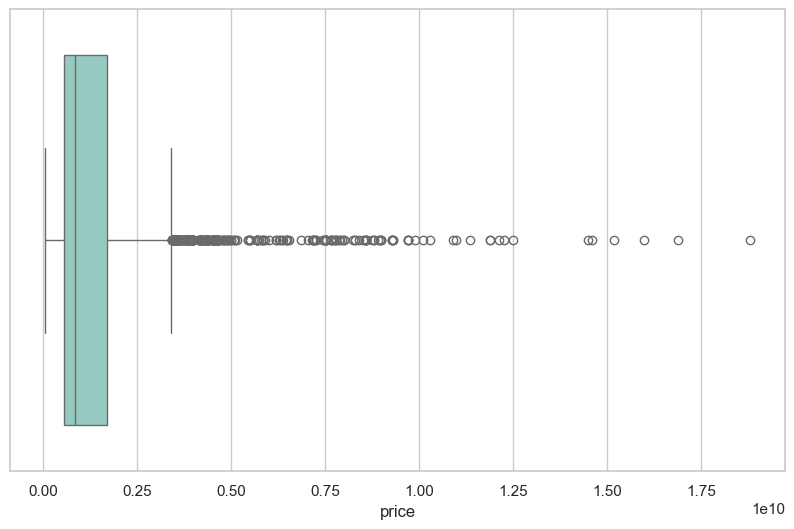

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") 

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="price",
    data=df_bonbanh,
    palette="Set3"  
)
plt.show()


In [13]:
cheapest_5 = df_bonbanh.nsmallest(5, 'price')
cheapest_5


,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,name,price
2649,2011,Xe đã dùng,"27,000 Km",Lắp ráp trong nước,Van/Minivan,Xăng 0.8 L,Bạc,Bạc,Chevrolet Spark Van 0 8 MT 2011 54 Triệu,54000000.0
896,2003,Xe đã dùng,"150,000 Km",Lắp ráp trong nước,Sedan,Xăng 1.6 L,Bạc,Kem,Mazda 323 Classic GLX 2003 73 Triệu,73000000.0
1746,2006,Xe đã dùng,0 Km,Lắp ráp trong nước,Sedan,Xăng 1.5 L,Đen,Nhiều màu,Toyota Vios 1 5 MT 2006 89 Triệu,89000000.0
380,2003,Xe đã dùng,"180,000 Km",Lắp ráp trong nước,Crossover,Xăng 1.8 L,Xanh,Kem,Mazda Premacy 1 8 AT 2003 92 Triệu,92000000.0
2505,2006,Xe đã dùng,"11,000 Km",Nhập khẩu,Hatchback,Xăng 1.0 L,Bạc,Kem,Daihatsu Charade 1 0 AT 2006 99 Triệu,99000000.0


In [14]:
most_expensive_5 = df_bonbanh.nlargest(5, 'price')
most_expensive_5

,Năm_sản_xuất,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,name,price
2509,2022,Xe đã dùng,0 Km,Nhập khẩu,Coupe,Xăng 3.0 L,Vàng,Đen,Ferrari 296 GTB 2022 18 Tỷ 800 Triệu,1.880000e+10
1181,2015,Xe đã dùng,"20,000 Km",Nhập khẩu,Coupe,Xăng 6.5 L,Vàng,Đen,Lamborghini Aventador LP 700 4 2015 16 Tỷ 900 ...,1.690000e+10
837,2024,Xe mới,None,Nhập khẩu,Sedan,Xăng 6.0 L,Đen,Kem,Mercedes Benz Maybach S680 4Matic 2024 15 Tỷ 9...,1.599000e+10
836,2024,Xe mới,None,Nhập khẩu,Sedan,Xăng 6.0 L,Đen,Kem,Mercedes Benz Maybach S680 4Matic 2024 15 Tỷ 1...,1.519900e+10
1107,2025,Xe đã dùng,"2,200 Km",Nhập khẩu,SUV,Hybrid 3.0 L,Đen,Nâu,LandRover Range Rover Autobiography LWB P460e ...,1.459000e+10


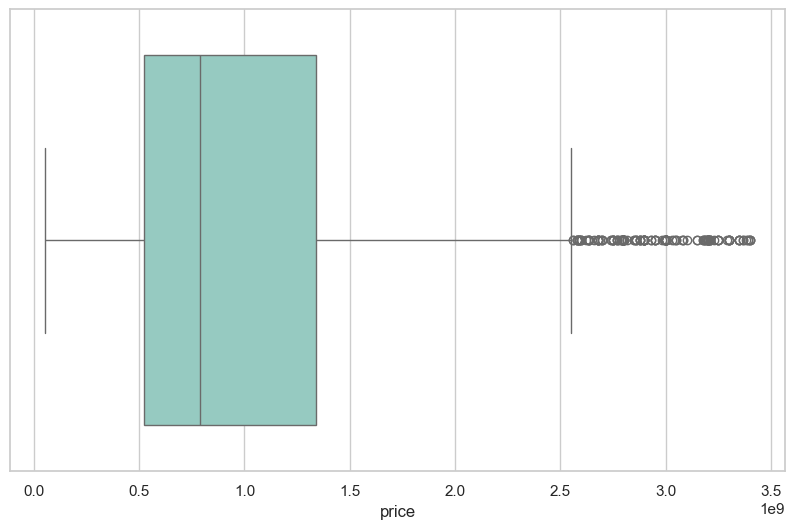

In [15]:
df_bonbanh = remove_outliers_iqr(df_bonbanh, 'price')

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="price",
    data=df_bonbanh,
    palette="Set3"  
)
plt.show()

3.brand

In [16]:
df_bonbanh["brand"] = df_bonbanh["name"].str.strip().str.split().str[0]

In [17]:
df_bonbanh["brand"].unique()

array(['VinFast', 'Volkswagen', 'Volvo', 'Toyota', 'Mazda', 'Mercedes',
       'Lexus', 'Lynk', 'MG', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'LandRover', 'Hyundai', 'Infiniti', 'Mitsubishi', 'Mini',
       'Peugeot', 'Porsche', 'Smart', 'Ssangyong', 'Subaru', 'Suzuki',
       'Nissan', 'Omoda', 'Ford', 'GAC', 'Gaz', 'Haval', 'Honda', 'BMW',
       'Chevrolet', 'Citroen', 'Daewoo', 'Daihatsu', 'Dodge', 'Dongfeng',
       'BYD', 'Cadillac', 'Chenglong', 'Audi', 'Bentley', 'Bestune'],
      dtype=object)

4.year

In [18]:
df_bonbanh["Năm_sản_xuất"].head(5)

0    2025
1    2024
2    2024
3    2024
4    2025
Name: Năm_sản_xuất, dtype: object

In [19]:
df_bonbanh["age"] = 2025 - df_bonbanh["Năm_sản_xuất"].astype(int)
df_bonbanh.drop(columns=["Năm_sản_xuất"], inplace=True)
df_bonbanh.head(1)

,Tình_trạng,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,name,price,brand,age
0,Xe mới,None,Lắp ráp trong nước,SUV,Điện,Hồng,Đen,VinFast VF3 2025 275 Triệu,275000000.0,VinFast,0


5.status

In [20]:
df_bonbanh["Tình_trạng"].unique()

array(['Xe mới', 'Xe đã dùng'], dtype=object)

In [21]:
df_bonbanh = df_bonbanh[df_bonbanh["Tình_trạng"] == "Xe đã dùng"]
df_bonbanh.drop(columns=["Tình_trạng"], inplace=True)

In [22]:
df_bonbanh.head(1)

,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,name,price,brand,age
1,"22,000 Km",Lắp ráp trong nước,Hatchback,Điện,Xám,Nhiều màu,VinFast VF3 Plus 2024 225 Triệu,225000000.0,VinFast,1


6.km

In [23]:
df_bonbanh["Số_Km_đã_đi"].head(5)

1    22,000 Km
2    10,012 Km
3    10,000 Km
5         0 Km
6     1,340 Km
Name: Số_Km_đã_đi, dtype: object

In [24]:
df_bonbanh = clean_km(df_bonbanh, "Số_Km_đã_đi")

In [25]:
df_bonbanh.head(1)

,Số_Km_đã_đi,Xuất_xứ,Kiểu_dáng,Động_cơ,Màu_ngoại_thất,Màu_nội_thất,name,price,brand,age
1,22000.0,Lắp ráp trong nước,Hatchback,Điện,Xám,Nhiều màu,VinFast VF3 Plus 2024 225 Triệu,225000000.0,VinFast,1


In [26]:
df_bonbanh.rename(columns={"Số_Km_đã_đi": "km"}, inplace=True)
df_bonbanh = df_bonbanh[df_bonbanh["km"] > 100]
df_bonbanh = df_bonbanh.reset_index(drop=True)


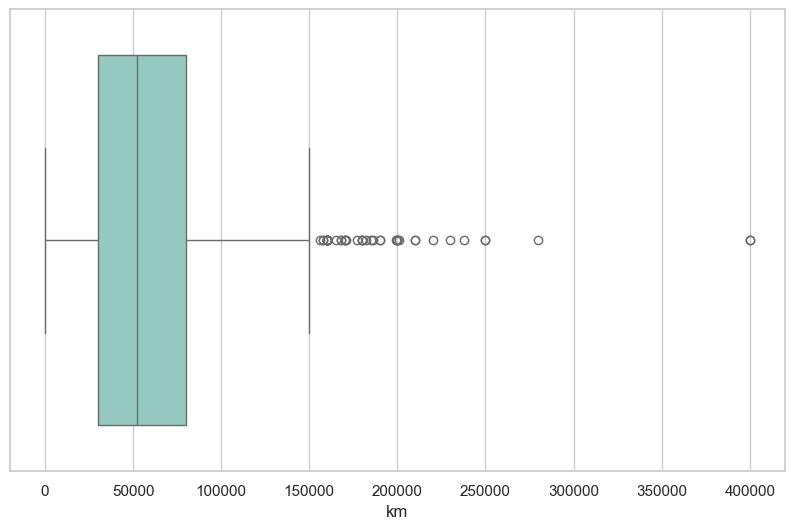

In [27]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="km",
    data=df_bonbanh,
    palette="Set3"  
)
plt.show()

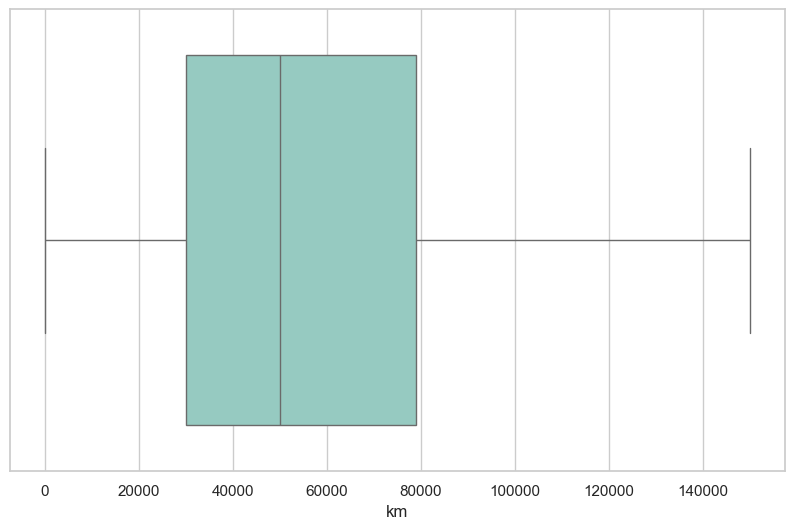

In [28]:
df_bonbanh = remove_outliers_iqr(df_bonbanh, 'km')
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="km",
    data=df_bonbanh,
    palette="Set3"  
)
plt.show()

7.origin

In [29]:
df_bonbanh["Xuất_xứ"].unique()

array(['Lắp ráp trong nước', 'Nhập khẩu'], dtype=object)

In [30]:
df_bonbanh = df_bonbanh.rename(columns={"Xuất_xứ": "origin"})

In [31]:
df_bonbanh["origin"] = df_bonbanh["origin"].replace({
    "Lắp ráp trong nước": "trong nước",
    "Nhập khẩu": "nhập khẩu"
})


8.body

In [32]:
df_bonbanh["Kiểu_dáng"].unique()

array(['Hatchback', 'SUV', 'Sedan', 'Crossover', 'Van/Minivan',
       'Bán tải / Pickup', 'Coupe', 'Truck', 'Convertible/Cabriolet'],
      dtype=object)

In [33]:
df_bonbanh = df_bonbanh.rename(columns={"Kiểu_dáng": "body"})
df_bonbanh["body"] = df_bonbanh["body"].str.lower().str.strip()

9.fuel

In [34]:
df_bonbanh["Động_cơ"].unique()

array(['Điện', 'Xăng  2.0 L', 'Điện  0.6 L', 'Điện  0.2 L',
       'Hybrid  2.0 L', 'Xăng  1.5 L', 'Xăng  1.2 L', 'Xăng  1.3 L',
       'Xăng  1.4 L', 'Xăng  1.8 L', 'Xăng  1.6 L', 'Xăng  2.5 L',
       'Xăng  2.4 L', 'Xăng  3.5 L', 'Dầu  2.2 L', 'Hybrid  1.5 L',
       'Xăng  3.0 L', 'Xăng  4.7 L', 'Xăng  5.5 L', 'Dầu  2.1 L',
       'Hybrid  3.0 L', 'Dầu  3.0 L', 'Xăng  6.0 L', 'Xăng  5.0 L',
       'Xăng', 'Hybrid  1.6 L', 'Dầu  2.0 L', 'Hybrid  1.8 L',
       'Hybrid  2.5 L', 'Xăng  4.6 L', 'Xăng  1.25 L', 'Xăng  1.0 L',
       'Xăng  3.3 L', 'Dầu  2.5 L', 'Hybrid  5.0 L', 'Xăng  5.7 L', 'Dầu',
       'Xăng  3.7 L', 'Dầu  1.9 L', 'Xăng  2.7 L', 'Dầu  2.8 L',
       'Dầu  2.4 L', '-', 'Xăng  4.0 L', 'Xăng  3.6 L', 'Xăng  4.8 L',
       'Xăng  3.2 L', 'Xăng  4.5 L', 'Dầu  2.3 L', 'Dầu  3.2 L',
       'Xăng  6.2 L', 'Xăng  0.8 L', 'Xăng  1.1 L', 'Xăng  2.3 L'],
      dtype=object)

In [35]:
df_bonbanh = df_bonbanh.rename(columns={"Động_cơ": "fuel"})
df_bonbanh["fuel"] = df_bonbanh["fuel"].apply(clean_fuel)

In [36]:
df_bonbanh["fuel"].unique()

array(['Điện', 'Xăng', 'Hybrid', 'Dầu', 'Khác'], dtype=object)

In [37]:
df_bonbanh.head(5)

,km,origin,body,fuel,Màu_ngoại_thất,Màu_nội_thất,name,price,brand,age
0,22000.0,trong nước,hatchback,Điện,Xám,Nhiều màu,VinFast VF3 Plus 2024 225 Triệu,225000000.0,VinFast,1
1,10012.0,trong nước,hatchback,Điện,Xám,Nhiều màu,VinFast VF3 Plus 2024 222 Triệu,222000000.0,VinFast,1
2,10000.0,trong nước,hatchback,Điện,Vàng,Nhiều màu,VinFast VF3 Plus 2024 225 Triệu,225000000.0,VinFast,1
3,1340.0,trong nước,hatchback,Điện,Đỏ,Kem,VinFast VF3 Plus 2025 240 Triệu,240000000.0,VinFast,0
4,8000.0,trong nước,hatchback,Điện,Vàng,Đen,VinFast VF3 Plus 2025 269 Triệu,269000000.0,VinFast,0


10.dropna

In [38]:
df_bonbanh.drop(columns=["Màu_ngoại_thất", "Màu_nội_thất"], inplace=True)
df_bonbanh = df_bonbanh.dropna()

In [39]:
df_bonbanh.head(10)

,km,origin,body,fuel,name,price,brand,age
0,22000.0,trong nước,hatchback,Điện,VinFast VF3 Plus 2024 225 Triệu,225000000.0,VinFast,1
1,10012.0,trong nước,hatchback,Điện,VinFast VF3 Plus 2024 222 Triệu,222000000.0,VinFast,1
2,10000.0,trong nước,hatchback,Điện,VinFast VF3 Plus 2024 225 Triệu,225000000.0,VinFast,1
3,1340.0,trong nước,hatchback,Điện,VinFast VF3 Plus 2025 240 Triệu,240000000.0,VinFast,0
4,8000.0,trong nước,hatchback,Điện,VinFast VF3 Plus 2025 269 Triệu,269000000.0,VinFast,0
5,5000.0,trong nước,hatchback,Điện,VinFast VF3 Plus 2025 235 Triệu,235000000.0,VinFast,0
6,7000.0,trong nước,hatchback,Điện,VinFast VF3 Plus 2025 235 Triệu,235000000.0,VinFast,0
7,42000.0,trong nước,suv,Điện,VinFast VF5 Plus 2023 430 Triệu,430000000.0,VinFast,2
8,65000.0,trong nước,suv,Điện,VinFast VF5 Plus 2023 399 Triệu,399000000.0,VinFast,2
9,20000.0,trong nước,suv,Điện,VinFast VF5 Plus 2024 429 Triệu,429000000.0,VinFast,1


In [40]:
df_bonbanh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2044 entries, 0 to 2088
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   km      2044 non-null   float64
 1   origin  2044 non-null   object 
 2   body    2044 non-null   object 
 3   fuel    2044 non-null   object 
 4   name    2044 non-null   object 
 5   price   2044 non-null   float64
 6   brand   2044 non-null   object 
 7   age     2044 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 143.7+ KB


11.updata

In [41]:
upload_to_bigquery(df_bonbanh, table_id=table_id, if_exists="append" )

✅ Uploaded 2044 rows to khangtestdbt.xecupredict.data_cleaned


In [42]:
# end